<a href="https://colab.research.google.com/github/qmaruf/fastai/blob/master/fast_ai_bounding_box_around_the_largest_object.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
print (sys.version)

import sys
print (sys.version)

# ! pip3 install fastai==0.7.0
# ! pip3 install torchtext==0.2.3

# ! pip3 install torch
# ! pip3 install torchvision

%matplotlib inline
%reload_ext autoreload
%autoreload 2

# from fastai.conv_learner import *
# from fastai.dataset import *

import torch
import torch.nn as nn
from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
import torch.optim as optim
import time, copy
torch.cuda.set_device(0)

# !mkdir data
# !wget http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar -P data/
# !wget https://storage.googleapis.com/coco-dataset/external/PASCAL_VOC.zip -P data/
# !tar -xf data/VOCtrainval_06-Nov-2007.tar -C data/
# !unzip data/PASCAL_VOC.zip -d data/
# !rm -rf data/PASCAL_VOC.zip data/VOCtrainval_06-Nov-2007.tar

3.6.7 (default, Oct 22 2018, 11:32:17) 
[GCC 8.2.0]
3.6.7 (default, Oct 22 2018, 11:32:17) 
[GCC 8.2.0]


In [0]:
import collections
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(1971)

In [3]:
PATH = Path('data/PASCAL_VOC/')
list(PATH.iterdir())

[PosixPath('data/PASCAL_VOC/pascal_train2012.json'),
 PosixPath('data/PASCAL_VOC/pascal_train2007.json'),
 PosixPath('data/PASCAL_VOC/pascal_test2007.json'),
 PosixPath('data/PASCAL_VOC/pascal_val2012.json'),
 PosixPath('data/PASCAL_VOC/pascal_val2007.json')]

In [0]:
train_json = json.load((PATH/'pascal_train2007.json').open())

In [5]:
train_json.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

In [0]:
IMAGES, TYPE, ANNOTATIONS, CATEGORIES = ['images', 'type', 'annotations', 'categories']

In [7]:
images_dir = Path('./data/VOCdevkit/VOC2007/JPEGImages/')
next(images_dir.iterdir())

PosixPath('data/VOCdevkit/VOC2007/JPEGImages/006595.jpg')

In [0]:
# dictionary to keep image_id vs bbox and and corresponding category
annotation_dict = collections.defaultdict(lambda:[])
for item in train_json[ANNOTATIONS]:
#     print (item['image_id'])
#     print (item['bbox'])
#     print (item['category_id'])
    annotation_dict[item['image_id']].append((item['category_id'], item['bbox']))
#     break

In [9]:
len(annotation_dict)

2501

In [0]:
# dictionary to keep image id to image path
image_id_to_filename = dict()
for item in train_json[IMAGES]:
    image_id_to_filename[item['id']]= images_dir/item['file_name']

In [0]:
image_id_to_category = dict()
for item in train_json[CATEGORIES]:
    image_id_to_category[item['id']]=item['name']
    
id_to_WH = dict()
for item in train_json[IMAGES]:
    id_to_WH[item['id']]={'height':item['height'], 'width':item['width']}

In [0]:
# image_id_to_filename

In [0]:
def coord_to_hw(bb):
    return np.array([bb[0], bb[1], bb[2]-bb[0]+1, bb[3]-bb[1]+1])

def hw_to_coord(bb, image_id=None, normalize=None):
    if normalize == True and image_id is not None:
        xmin = bb[0]/id_to_WH[image_id]['width']
        ymin = bb[1]/id_to_WH[image_id]['height']
        xmax = (bb[0]+bb[2])/id_to_WH[image_id]['width']
        ymax = (bb[1]+bb[3])/id_to_WH[image_id]['height']
        return np.array([xmin, ymin, xmax, ymax])
    else:
        return np.array([bb[0], bb[1], bb[0]+bb[2], bb[1]+bb[3]])

def draw_image(image, figsize=None, ax=None):
    if ax is None: 
        fig, ax = plt.subplots()
    ax.imshow(image)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def draw_bbox(ax, bbox):
    rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], fill=False, edgecolor='white', linewidth=2)
    ax.add_patch(rect)
    
def add_text(ax, bb, txt):
    text = ax.text(bb[0], bb[1], txt, fontsize=14, color='white', weight='bold', backgroundcolor='black') 
    
def read_image(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

from sklearn.preprocessing import LabelEncoder

class CategoryUtil:
    def __init__(self, labels):
        self.labels = np.unique(labels)
        self.encode_dict = dict()
        self.decode_dict = dict()
        for id, label in enumerate(self.labels):
            self.encode_dict[label] = id
            self.decode_dict[id] = label
            
    def encode(self, label):
        return self.encode_dict[label]
    
    def decode(self, id):
        return self.decode_dict[id]

(15, [184, 61, 95, 138])
(13, [89, 77, 314, 259])


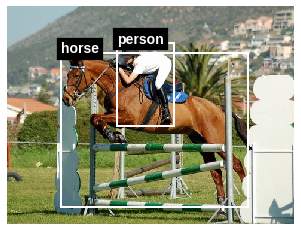

In [15]:
image_id = 17
image = read_image(str(image_id_to_filename[image_id]))
ax = draw_image(image)
for bbox in annotation_dict[image_id]:
    print (bbox)
    draw_bbox(ax, bbox[1])
    add_text(ax, bbox[1], image_id_to_category[bbox[0]])

In [0]:
annotation_dict_large = dict()
for image_id in annotation_dict:
    bboxes = (annotation_dict[image_id])
    lrg_bb = sorted(bboxes, key=lambda x: x[1][2]*x[1][3], reverse=True)[0]
    lrg_bb[0] = id_to_WH[image_id]['width']
    annotation_dict_large[image_id]=lrg_bb

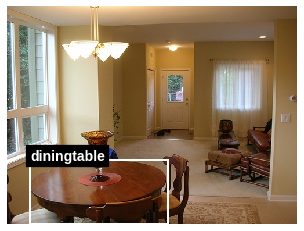

In [17]:
image_id = 235
image = read_image(str(image_id_to_filename[image_id]))
ax = draw_image(image)
draw_bbox(ax, annotation_dict_large[image_id][1])
add_text(ax, annotation_dict_large[image_id][1], image_id_to_category[annotation_dict_large[image_id][0]])

In [125]:
df = pd.DataFrame(
{
    'image_path': [image_id_to_filename[id] for id in annotation_dict_large],
    'category': [image_id_to_category[annotation_dict_large[id][0]] for id in annotation_dict_large],
    'bbox': [','.join(list(map(str, hw_to_coord(
        annotation_dict_large[id][1], id, normalize=True)))) for id in annotation_dict_large]
})


df.head()

,bbox,category,image_path
0,"0.31,0.2882882882882883,0.702,0.8108108108108109",car,data/VOCdevkit/VOC2007/JPEGImages/000012.jpg
1,"0.18541666666666667,0.21153846153846154,0.8395...",horse,data/VOCdevkit/VOC2007/JPEGImages/000017.jpg
2,"0.005988023952095809,0.002,0.7275449101796407,...",person,data/VOCdevkit/VOC2007/JPEGImages/000023.jpg
3,"0.178,0.37237237237237236,0.674,0.636636636636...",car,data/VOCdevkit/VOC2007/JPEGImages/000026.jpg
4,"0.206,0.27402135231316727,0.75,0.6512455516014235",aeroplane,data/VOCdevkit/VOC2007/JPEGImages/000032.jpg


In [0]:
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from glob import glob
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

input_size = 224
data_transforms = {
    'train': transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

class MyCustomDataset(Dataset):
    def __init__(self, df, phase):
        self.df = df
        self.transforms = data_transforms[phase]              
        
    def __getitem__(self, index):
        image = read_image(str(self.df.iloc[index]['image_path']))
        image = self.transforms(image)        
        label = catutil.encode(self.df.iloc[index]['category'])
        bbox = self.df.iloc[index]['bbox']
        bbox = torch.tensor(list(map(float, bbox.split(','))))
        return image, label, bbox

    def __len__(self):
        return self.df.shape[0]


df = df.sample(frac=1)

n_train = int(df.shape[0]*80/100)
n_val = df.shape[0] - n_train
df_train = df.head(n_train)
df_val = df.tail(n_val)

catutil = CategoryUtil(df.category)

dataset = MyCustomDataset(df_train, 'train')
train_data_loader = DataLoader(dataset, batch_size=16, shuffle=True)

dataset = MyCustomDataset(df_val, 'val')
val_data_loader = DataLoader(dataset, batch_size=16, shuffle=False)

dataloaders_dict = {
    'train': train_data_loader,
    'val': val_data_loader
}

In [128]:
df.head()

,bbox,category,image_path
2489,"0.148,0.34,0.834,0.6625",aeroplane,data/VOCdevkit/VOC2007/JPEGImages/009911.jpg
303,"0.08857808857808858,0.05,0.5337995337995338,0.824",cow,data/VOCdevkit/VOC2007/JPEGImages/001299.jpg
1269,"0.236,0.15615615615615616,0.978,0.570570570570...",aeroplane,data/VOCdevkit/VOC2007/JPEGImages/005016.jpg
1850,"0.184,0.058666666666666666,0.896,0.792",cat,data/VOCdevkit/VOC2007/JPEGImages/007334.jpg
2186,"0.368,0.3153153153153153,0.674,0.5705705705705706",aeroplane,data/VOCdevkit/VOC2007/JPEGImages/008770.jpg


In [0]:
# for data in data_loader:
#     print (data[0])
#     break

In [0]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels, bboxes in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                bboxes = bboxes.to(device).to(dtype=torch.float)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, bboxes)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                

            epoch_loss = running_loss / len(dataloaders[phase].dataset)


            print('{} Loss: {:.4f}'.format(phase, epoch_loss))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_loss_history.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_loss_history

In [0]:
import torchvision as tv

In [0]:
model_ft = tv.models.resnet101(pretrained=True)
set_parameter_requires_grad(model_ft, feature_extracting=True)
num_ftrs = model_ft.fc.in_features



# 4 output , xmin, ymin, xmax, ymax
num_classes = 4 
model_ft.fc = nn.Linear(num_ftrs, num_classes)

In [0]:
# model_ft

In [134]:
data_transforms['train']

Compose(
    ToPILImage()
    RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [135]:
len(np.unique(df.category.values))

20

In [0]:
# torch.cuda.get_device_name(1)

In [137]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print (device)

cuda:0


In [0]:
model_ft = model_ft.to(device)

In [0]:
params_to_update = []
for name, param in model_ft.named_parameters():
    if param.requires_grad:
        params_to_update.append(param)

In [0]:
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

In [0]:
criterion = nn.MSELoss()
num_epochs=128

In [142]:
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=False)
torch.save(model_ft.state_dict(),'./model_ft.pth')

Epoch 0/1
----------
train Loss: 0.0778
val Loss: 0.0533

Epoch 1/1
----------
train Loss: 0.0412
val Loss: 0.0484

Training complete in 1m 49s
Best val Loss: 0.048419


In [0]:
#==============

def denormalize(image, _mean=None, _std=None):
    if _mean is None and _std is None:
        _mean = [0.485, 0.456, 0.406]
        _std = [0.229, 0.224, 0.225]
    for i in range(3):
        image[:, i, :, :] = image[:, i, :, :] * _std[i] + _mean[i]
    return image

tensor([ 46.1440,  61.3808, 168.0000, 145.8790], device='cuda:0')
tensor([149.1840,   0.0000, 172.9280,  65.7067], device='cuda:0')
tensor([112.8960, 117.8623, 178.7520, 188.8264], device='cuda:0')
tensor([118.2720,  30.2703, 219.9680, 224.0000], device='cuda:0')
tensor([  7.1680,   2.6540, 208.3200, 224.0000], device='cuda:0')
tensor([ 68.6126,  70.7840, 151.3513, 166.6560], device='cuda:0')
tensor([120.9600,  47.1893, 224.0000, 224.0000], device='cuda:0')
tensor([ 23.2960,  93.1840, 200.7040, 214.4427], device='cuda:0')
tensor([ 84.2240, 110.5067, 139.7760, 137.3867], device='cuda:0')
tensor([ 77.7964,  34.9440, 173.0299, 180.5440], device='cuda:0')
tensor([  5.3653,  94.9760, 215.2814, 187.7120], device='cuda:0')
tensor([ 50.1760,  68.3721, 169.7920, 170.6046], device='cuda:0')
tensor([ 46.1440,  54.8085, 209.2160, 212.6808], device='cuda:0')
tensor([ 45.6960,  89.6000,  70.3360, 125.9243], device='cuda:0')
tensor([107.9680,  78.2651, 157.6960, 207.8072], device='cuda:0')
tensor([  

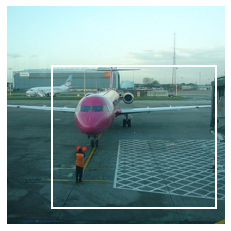

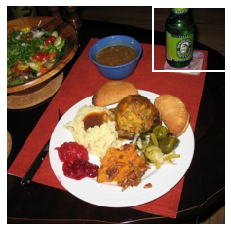

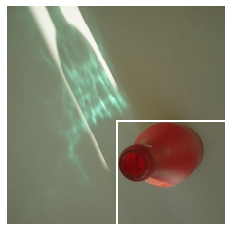

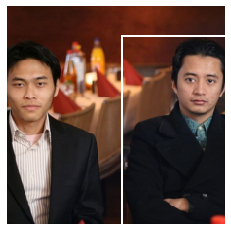

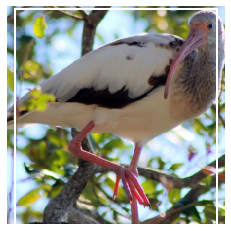

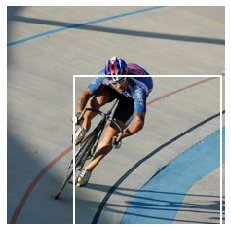

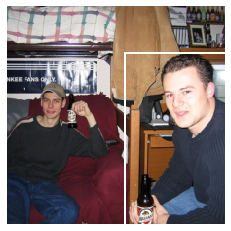

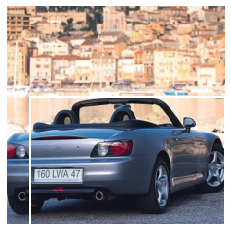

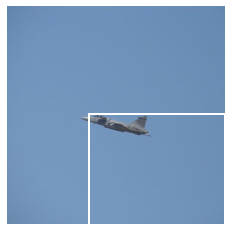

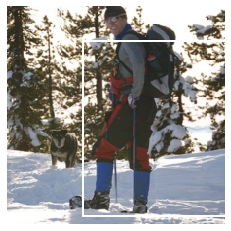

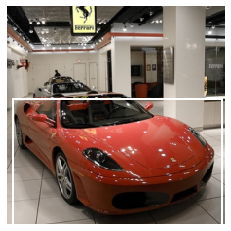

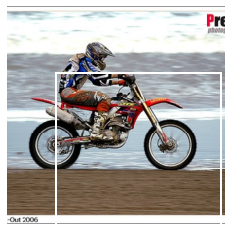

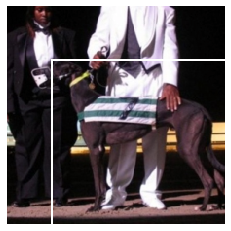

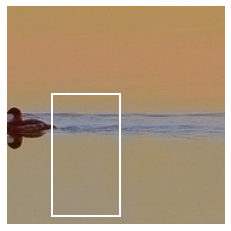

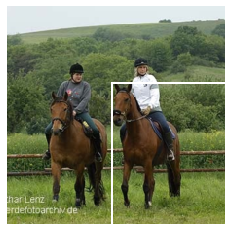

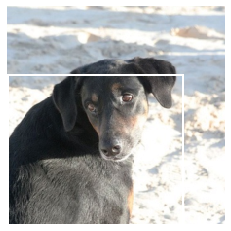

In [147]:
to_pil = transforms.ToPILImage()
for inputs, labels, bboxes in val_data_loader:
    inputs, bboxes = inputs.cuda(), bboxes.cuda()
    predictions = model_ft(inputs)
    inputs = denormalize(inputs)
    predictions = predictions.cpu().data.numpy().astype(int)
    for inp, bbox in zip(inputs, bboxes):
        ax = draw_image(to_pil(inp.cpu()))
        bbox[0], bbox[2] = bbox[0] * 224.0, bbox[2] *224.0
        bbox[1], bbox[3] = bbox[1] * 224.0, bbox[3] * 224.0
        draw_bbox(ax, bbox)
        print (bbox)
#         lbl = catutil.decode(lbl.item())
#         add_text(ax, [5, 5], lbl)
    break

In [114]:
predictions.cpu().data.numpy().astype(int)

array([[ 89,  88, 376, 442],
       [ 38,  63, 337, 390],
       [141, 164, 300, 334],
       [ 60,  41, 307, 423],
       [151, 150, 304, 407],
       [ 93,  95, 343, 377],
       [ 54,  92, 329, 361],
       [160, 163, 294, 337],
       [119, 130, 379, 460],
       [123, 158, 323, 343],
       [ 74,  87, 319, 392],
       [126, 165, 193, 260],
       [ 77,  94, 280, 353],
       [ 62, 113, 344, 435],
       [106, 117, 327, 330],
       [113, 200, 314, 335]])

In [0]:
train_hist = [h.item() for h in hist]

Text(0, 0.5, 'validation accuracy')

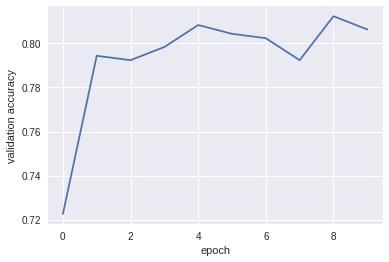

In [0]:
plt.plot(train_hist)
plt.xlabel('epoch')
plt.ylabel('validation accuracy')

In [36]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [0]:
model_ft = model_ft.cuda()
for data in train_data_loader:
    inputs, labels, bboxes = data
    inputs = inputs.cuda()
    bboxes = bboxes.cuda()
    outputs = model_ft(inputs)
    break

In [56]:
outputs, bboxes.to(dtype=torch.float)

(tensor([[ 0.1115,  0.1982, -0.0131, -0.1625],
         [ 0.0737,  0.2110, -0.0753, -0.0910],
         [-0.0565, -0.1802,  0.1643, -0.1547],
         [ 0.2382,  0.3328, -0.1085,  0.0294],
         [-0.1604,  0.2871,  0.0157, -0.2002],
         [ 0.2606,  0.6084, -0.2495, -0.3245],
         [ 0.2598,  0.3806, -0.0641,  0.4159],
         [-0.1551,  0.3574, -0.4133, -0.3363],
         [ 0.2294,  0.0781,  0.2078,  0.0834],
         [ 0.0212,  0.0304,  0.0413, -0.2800],
         [ 0.2835,  0.1593, -0.0498, -0.0709],
         [-0.0616,  0.5601,  0.0089, -0.2426],
         [ 0.1955,  0.1793, -0.0663,  0.2222],
         [-0.2856,  0.2744,  0.0482,  0.0436],
         [ 0.2682,  0.1724,  0.0907, -0.2121],
         [-0.5088, -0.3944,  0.0101, -0.2601]], device='cuda:0',
        grad_fn=<AddmmBackward>), tensor([[  0., 246., 149., 418.],
         [ 32.,  22., 353., 482.],
         [134., 146., 353., 235.],
         [ 37., 269., 167., 366.],
         [159., 129., 435., 232.],
         [ 20.,  74., 

In [57]:
nn.MSELoss()(outputs, bboxes.to(dtype=torch.float))

tensor(67812.0938, device='cuda:0', grad_fn=<MseLossBackward>)

In [53]:
type(outputs), type(bboxes)

(torch.Tensor, torch.Tensor)